In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import trange
from torch_geometric.data import Data
from torchvision.datasets import MNIST
from torch_pso import ParticleSwarmOptimizer

from sklearn.datasets import load_iris, load_digits

from gae import encode_dataset, AttentionDecoder, AttentionEncoder

In [9]:
dataset = MNIST(root='./data', download=True)
X = dataset.data.numpy().reshape(-1, 28 * 28)[:1000, :]
y = dataset.targets.numpy()[:1000]
# X, y = load_iris(return_X_y=True, as_frame=False)
X, E, W = encode_dataset(X, k=5, to='cuda:0', weights='weighted')

In [10]:
X.shape, E.shape

(torch.Size([1000, 784]), torch.Size([2, 5000]))

In [11]:
data = Data(edge_index=E, x=X, edge_attr=W)

In [12]:
in_feat = X.shape[1]
out_feat = 2

encoder = AttentionEncoder(in_feat, out_feat).to('cuda:0')
decoder = AttentionDecoder(out_feat, in_feat).to('cuda:0')

# inizialize the optimizer
optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=1e-5)
criterion = torch.nn.MSELoss()

In [15]:
def train():
    x, e, w = data.x, data.edge_index, data.edge_attr
    encoder.train()
    decoder.train()
    optimizer.zero_grad()
    z = encoder(x, e, w)
    x_hat = decoder(z, e, w)

    loss = criterion(x, x_hat)

    #if args.variational:
    #   loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return float(loss)

In [16]:
epochs = 1_000
epoch_loss = []
loop = trange(epochs)
for epoch in loop:
    loss = train()
    loop.set_description(f'Epoch {epoch:03d}, loss: {loss:.19f}')
    epoch_loss.append(loss)

Epoch 999, loss: 4217.2680664062500000000: 100%|██████████| 1000/1000 [00:07<00:00, 133.33it/s]


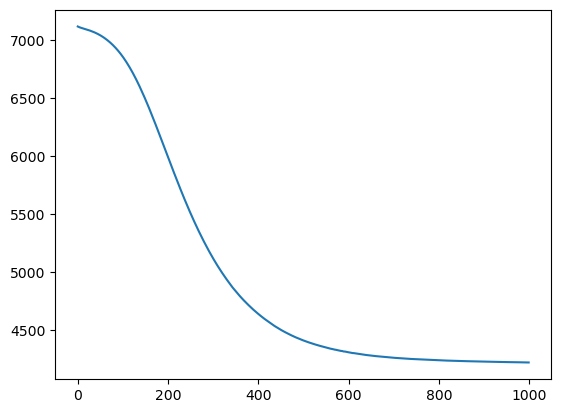

In [17]:
plt.plot(epoch_loss)

In [18]:
X_reduced = encoder(data.x, data.edge_index, data.edge_attr).detach().to('cpu').numpy()

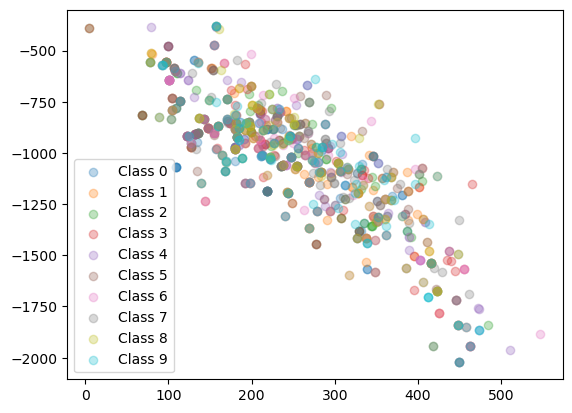

In [19]:
for cls in range(1 + y.max()):
    indices = y == cls
    X_cls = X_reduced[indices, :]
    plt.scatter(X_cls[:, 0], X_cls[:, 1], label=f'Class {cls}', alpha=0.3)

plt.legend(loc='best')